In [1]:
import pandas as pd
from pandas import option_context
import glob
import sys
sys.path.append('E:\GitHubProjects\dissertation\Scripts')
import helperfn as hf

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_colwidth', -1)

df = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\approved_datasets')

# df.iloc[[363,367]]

In [3]:
df.iloc[[363,367]]

,review,score
363,Fantastic environment and gorgeoud scenery. The clubs and societies provide great opportunities to meet life long friends.,1
367,Wifi drops off easily and applying for accommodation is stressful,0


In [5]:
# BALANCING THE DATASET
df.score.value_counts()


1    1901
0    946 
Name: score, dtype: int64

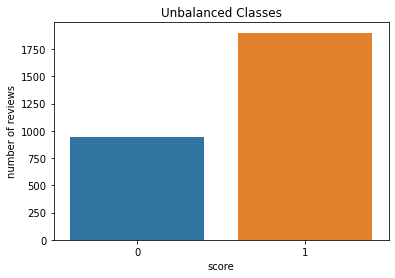

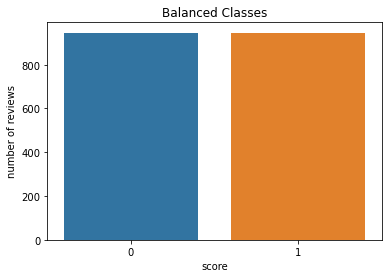

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Shuffle the dataset
shuffled_df = df.sample(frac=1, random_state=14)

# Put all negative reviews/class in a separate dataset.
negative_df = shuffled_df.loc[shuffled_df['score'] == 0]

#Randomly select 108 postive reviews (majority class), as there are 108 negative reviews
positive_df = shuffled_df.loc[shuffled_df['score'] == 1].sample(n=negative_df.shape[0])

# Concatenate both dataframes again
normalized_df = pd.concat([negative_df, positive_df])


sns.countplot('score', data=df)
plt.title('Unbalanced Classes')
plt.ylabel('number of reviews')
plt.show()


sns.countplot('score', data=normalized_df)
plt.title('Balanced Classes')
plt.ylabel('number of reviews')
plt.show()

In [27]:
from sklearn.model_selection import train_test_split
import numpy as np

In [32]:
normalized_df.score.value_counts()

1    946
0    946
Name: score, dtype: int64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df.review, normalized_df.score, test_size=0.2, shuffle=True, stratify=normalized_df.score, random_state=8)

frequenciesTrain = np.array(np.unique(y_train, return_counts=True)).T
frequenciesTest = np.array(np.unique(y_test, return_counts=True)).T

print("Training in total on: ", len(X_train))
print("Training on: ", frequenciesTrain)
print("Testing in total on: ", len(X_test))
print("Testing on: ", frequenciesTest)

Training in total on:  1513
Training on:  [[  0 757]
 [  1 756]]
Testing in total on:  379
Testing on:  [[  0 189]
 [  1 190]]


In [6]:
# TEST-SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['score'], test_size=0.33)

## Testing the performance on Tweets dataset
Using the same pipeline (set of methods as used in the web application backend)

In [2]:
tweets_eva = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\tweets_dataset')
tweets_eva['sentiment'] = tweets_eva['sentiment'].str.replace('Negative', '0')
tweets_eva['sentiment'] = tweets_eva['sentiment'].str.replace('Positive', '1')
tweets_eva

,review,sentiment
0,"""The rapid spread of the club has met some hos...",0
1,Microbiologists! Bring your swabs to the Edinb...,1
2,A busy day of debating ahead of us. Tom and Eo...,1
3,Today was my last working day at Northumbria U...,1
4,ooo sun if u find a good course for uni in ed...,1
...,...,...
168,Never forget that the University of Glasgow re...,0
169,if you're not a student at glasgow uni and you...,1
170,Seizing Women in STEM Scholarship 2021 in the ...,1
171,#resignsarahsmith All these pro independence ...,0


In [40]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle as pk

# load ML model
model = load_model('40_simple.h5')
# load tokenizer
with open("tokenizer_m1.pickle", 'rb') as handle:
    tokenizer = pk.load(handle)
print("ML Model Loaded")

from nltk.tokenize import RegexpTokenizer
import re
import sys 
# sys.path.append('E:\GitHubProjects\dissertation\Scripts')
sys.path.append('..\..\Scripts')
import helperfn as hf

stop = hf.stop_words()
uni_names = hf.uni_names()

def getSentiment(tweets):
    tweets_sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(tweets_sequences, maxlen=137)
    sentiment = model.predict(padded).flatten().tolist()
    return sentiment

def cleanTweets(tweets):
    tweets = hf.remove_mentions(tweets)

    tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

    tweets = [tokenizer.tokenize(x) for x in tweets]

    # lower case
    tweets = [hf.lower_token(x) for x in tweets]

    # remove stop words
    # tweets = [item for item in tweets if item not in stop]
    tweets = [hf.remove_stopwords(x) for x in tweets]

    # remove university names as they impact accuracy, these words should be neutral sentiment 
    # tweets = [item for item in tweets if item not in uni_names]
    tweets = [hf.remove_uni_names(x) for x in tweets]

    # #reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
    tweets = [hf.remove_punctuations(x) for x in tweets]
    return tweets

def cleanSingle(text):
    # remove @ mentions or URL links
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

    text = tokenizer.tokenize(text)

    # lower case
    text = hf.lower_token(text)

    # remove stop words
    text = [item for item in text if item not in stop]

    # remove university names as they impact accuracy, these words should be neutral sentiment 
    text = [item for item in text if item not in uni_names]

    # reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
    text = hf.remove_punctuations(text)
    return text


from nltk.tokenize import sent_tokenize, word_tokenize
def sentimentSentence(tweets):
    allTweets = []
    for tweet in tweets:
        sentences = sent_tokenize(tweet) 
        sentencesClean = [cleanSingle(sentence) for sentence in sentences]    
        tweetSentiment = getSentiment(sentencesClean)
        singleTweet = [{"tweet": [{"sentence": sentences[i], "sentiment": tweetSentiment[i]} for i in range(len(sentences))]}]
        allTweets.append(singleTweet)

    return allTweets

def sentimentToString(pred):
    rounded = round(pred)
    if rounded == 0:
        return "Negative"
    else:
        return "Positive"

ML Model Loaded


Accuracy:  0.7514450867052023
Precision:  0.7407407407407407
Recall:  0.8421052631578947
F1-score:  0.7881773399014779
wrong:  43


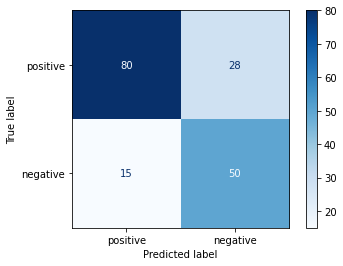

In [41]:
from sklearn.metrics import confusion_matrix
import graphs as gh
import numpy as np

tweets = tweets_eva['review'].tolist()
y_test = np.array(tweets_eva['sentiment'].tolist())
y_test = y_test.astype(int)

#PREDICT EACH TWEET VERSION
# cleaned = cleanTweets(tweets) 
# y_pred = getSentiment(cleaned)

#PREDICT EACH SENTENCE VERSION
y_pred = []
for tweet in tweets:
    sentences = sent_tokenize(tweet) 
    sentencesClean = [cleanSingle(sentence) for sentence in sentences]    
    tweetSentiment = getSentiment(sentencesClean)

    #get mean of sentences sentiment
    y_pred.append(np.mean(tweetSentiment))
    # y_pred.append(np.median(tweetSentiment))

    # np.average with optional weight parameter https://numpy.org/doc/stable/reference/generated/numpy.average.html
    # sentence_length = [len(sentence) for sentence in sentences]
    # total_length = np.sum(sentence_length)
    # #to get weights divide each element by total in array
    # weights = [length / total_length for length in sentence_length]
    # y_pred.append( np.average(tweetSentiment, weights=weights) )
    

y_pred = np.array(y_pred)
y_pred = np.where(y_pred > 0.5, 1, 0)

# # y_pred = (model.predict(cleaned).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
tp, fp, fn, tn = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
gh.conf_matrix(conf)

precision = tp / (tp+fp)
recall = tp / (tp+fn)
print("Accuracy: ", (tp+tn) / (tp+tn+fp+fn))
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", (2*precision*recall) / (precision+recall))
print("wrong: ", fn+fp)

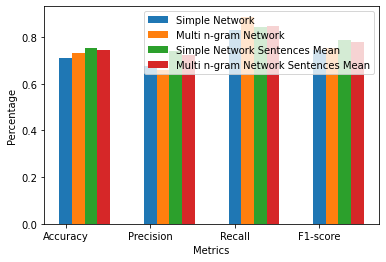

In [59]:
#CREATION OF HARDCODED GRAPH FOR COMPARING NETWORKS ON TWEETS
import matplotlib.pyplot as plt
bar_labels = ["Accuracy", "Precision", "Recall", "F1-score"]
dataSimple = [0.7109826589595376, 0.6759259259259259, 0.8295454545454546, 0.7448979591836735]
dataNgram = [0.7341040462427746, 0.6574074074074074, 0.8875, 0.7553191489361702]
dataSimpleMean = [0.7514450867052023, 0.7407407407407407, 0.8421052631578947, 0.7881773399014779]
dataNgramMean = [0.7456647398843931, 0.7222222222222222, 0.8478260869565217, 0.78]
width = 0.15
plt.bar(np.arange(len(dataSimple)), dataSimple, width=width, label="Simple Network")
plt.bar(np.arange(len(dataNgram))+ width, dataNgram, width=width, label="Multi n-gram Network")
plt.bar(np.arange(len(dataSimpleMean)) + width*2, dataSimpleMean, width=width, label="Simple Network Sentences Mean")
plt.bar(np.arange(len(dataNgramMean))+ width*3, dataNgramMean, width=width, label="Multi n-gram Network Sentences Mean")
# plt.title('model loss')
plt.xticks([0,1,2,3], bar_labels)
plt.ylabel('Percentage')
plt.xlabel('Metrics')
plt.legend()
plt.show()